In [57]:
%reset -f
%config InteractiveShell.ast_node_interactivity = 'all'

# Fetching all Air Quality datasets into their dataframes
# Perform immediate concatenation per year
import os
import pandas as pd

def gatherData(stateName, dataDir):
    # Initialize accumulator datasets using CO California datasets
    # NOTE: Dataset fragments are all in './StateAirData/'
    colidx = [0,2,4,17]
    innerkeys = ['Date', 'Site ID', 'COUNTY']       # Merge on Date, Site ID, and County
    dataA2020 = pd.read_csv(dataDir + stateName + '-2020-co.csv', parse_dates=True, usecols=colidx)
    dataA2021 = pd.read_csv(dataDir + stateName + '-2021-co.csv', parse_dates=True, usecols=colidx)
    dataA2022 = pd.read_csv(dataDir + stateName + '-2022-co.csv', parse_dates=True, usecols=colidx)

    # Iterate through the directory using os.scandir, and then get all the datasets there
    # Merge the remaining datasets other than ca-year-co to dataAyear
    with os.scandir(dataDir) as datasets:
        for dataset in datasets:
            if dataset.is_file() and 'co' not in dataset.name:
                temp = pd.read_csv(dataset, parse_dates=True, usecols=colidx)
                if stateName + '-2020' in dataset.name:
                    dataA2020 = pd.merge(dataA2020, temp, how='outer', on=innerkeys)
                elif stateName + '-2021' in dataset.name:
                    dataA2021 = pd.merge(dataA2021, temp, how='outer', on=innerkeys)
                elif stateName + '-2022' in dataset.name:
                    dataA2022 = pd.merge(dataA2022, temp, how='outer', on=innerkeys)

    # At this point, dataA2020, dataA2021, and dataA2022 have accumulated the dataset year fragments.

    # Parse Date to date
    dataA2020['Date'] = pd.to_datetime(dataA2020['Date'])
    dataA2021['Date'] = pd.to_datetime(dataA2021['Date'])
    dataA2022['Date'] = pd.to_datetime(dataA2022['Date'])

    # Group data by Date and Site ID, then by Date again to remove the Site ID feature
    # Result would be mean measurements per day
    dataA2020 = dataA2020.drop(columns=['Site ID'], axis=1).groupby(by=['Date'], as_index=False).mean()
    dataA2021 = dataA2021.drop(columns=['Site ID'], axis=1).groupby(by=['Date'], as_index=False).mean()
    dataA2022 = dataA2022.drop(columns=['Site ID'], axis=1).groupby(by=['Date'], as_index=False).mean()

    dataA = pd.concat([dataA2020, dataA2021, dataA2022])    # Combine the three datasets

    # Append State column to the data
    # dataA['State'] = stateName
    dataA.insert(1, 'State', stateName.upper(), True)

    return dataA

dataA = gatherData('ca', 'StateAirData/')
dataA = pd.concat([dataA, gatherData('ny', 'StateAirData/')])
dataA = pd.concat([dataA, gatherData('tx', 'StateAirData/')])
dataA


,Date,State,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
0,2020-01-01,CA,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
1,2020-01-02,CA,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2,2020-01-03,CA,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
3,2020-01-04,CA,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
4,2020-01-05,CA,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667
...,...,...,...,...,...,...,...,...,...
360,2022-12-27,TX,0.450000,24.692000,0.028536,NaN,64.000000,14.625000,8.746667
361,2022-12-28,TX,0.477778,22.370833,0.038855,NaN,87.000000,9.844444,10.040000
362,2022-12-29,TX,0.511111,18.686957,0.031614,NaN,25.000000,5.700000,7.806667
363,2022-12-30,TX,0.577778,19.843750,0.026099,NaN,18.000000,5.250000,5.713333


In [58]:
new_names = ['Date', 'State', 'CO conc (ppm)', 'NO2 conc (ppb)', 'O3 conc (ppm)',
             'Pb conc (ug/m3 SC)', 'PM10 conc (ug/m3 SC)',
             'PM2.5 conc (ug/m3 LC)', 'SO2 conc (ppb)']

# Rename columns
for i in range(len(new_names)):
    dataA.rename(columns={dataA.columns[i]: new_names[i]}, inplace=True)

print("dataA columns renamed:")
dataA.head()

dataA columns renamed:


,Date,State,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
0,2020-01-01,CA,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
1,2020-01-02,CA,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2,2020-01-03,CA,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
3,2020-01-04,CA,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
4,2020-01-05,CA,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667


In [59]:
import seaborn as sns

# Deciding whether to drop or impute null values, so we check how many null values there are.
# Dataset A impute
dataA.dropna(inplace=True)

print("A: Number of entries with null values:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

A: Number of entries with null values: 0
A: Number of entries: 921


In [60]:
# These imports are important, imputer relies on them.

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer   # Important!
from sklearn.impute import IterativeImputer     # default imputer is BayesianRidge

from sklearn.linear_model import BayesianRidge

# Other estimators (estimator = func()) to try
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialize imputer
# NOTE: DIFFERENT ESTIMATORS WERE TRIED HERE, from DecisionTreeRegressor() to KNeighborsRegressor()
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge())

# Perform imputation (note that convergence was quickly reached, indicating a good imputation)
# Imputation done separately from dataB to ensure impartiality of resulting values
backup = pd.DataFrame().assign(Date=dataA['Date'], State=dataA['State'])
dataA.drop(['Date', 'State'], axis=1, inplace=True)

dataA[:] = imp.fit_transform(dataA)

print("After imputation:")
dataA.head()
print("A: Number of entries with null values after impute:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

dataA.insert(0, 'Date', backup.Date)
dataA.insert(1, 'State', backup.State)

dataA

[IterativeImputer] Completing matrix with shape (921, 7)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.22167032967032968 
[IterativeImputer] Early stopping criterion reached.
After imputation:


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
0,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
1,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
3,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
4,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667


A: Number of entries with null values after impute: 0
A: Number of entries: 921


,Date,State,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
0,2020-01-01,CA,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
1,2020-01-02,CA,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2,2020-01-03,CA,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
3,2020-01-04,CA,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
4,2020-01-05,CA,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667
...,...,...,...,...,...,...,...,...,...
340,2022-12-07,TX,0.500000,13.177083,0.020842,0.017333,28.000000,8.190000,5.713793
346,2022-12-13,TX,0.333333,13.631250,0.026792,0.000500,15.333333,10.466667,4.186207
352,2022-12-19,TX,0.330000,13.120408,0.025472,0.001333,13.240000,4.990000,5.420000
358,2022-12-25,TX,0.800000,24.800000,0.033783,0.001000,33.750000,5.800000,8.786667


In [61]:
colidx = [0,1,2,3,5,6]     # column indexes to use (based on preemptively looking at dataB)
dataB = pd.read_csv('datasets/us_covid_cases_and_deaths_by_state.csv', parse_dates=True, usecols=colidx)

# ASSUMPTION: Let us treat all probable cases as an actual new case.
# We can do this because there are many dates where there are zero infections in dataB, but science would say that there's always background transmission going on, especially in the case of COVID-19 which is airborne and isn't always symptomatic.
sum_new_cases = dataB['new_case'] + dataB['pnew_case']
dataB.drop(['new_case', 'pnew_case'], axis=1, inplace=True)
dataB['sum_new_cases'] = sum_new_cases
dataB.head()

# Rename dataB columns to names comparable to dataA
# Note that we designated new_case + pnew_case as the column 'Sum New Cases'
dataB.columns = ['Date', 'State', 'Total Cases', 'Confirmed Cases', 'Sum New Cases']

dataB['Date'] = pd.to_datetime(dataB['Date'])

# Filter dataset B to just the states of CA and NY
dataB = dataB[(dataB['State'] == 'CA') | (dataB['State'] == 'NY') | (dataB['State'] == 'TX')]
dataB.head()

,submission_date,state,tot_cases,conf_cases,sum_new_cases
0,03/11/2021,KS,297229,241035.0,0.0
1,12/01/2021,ND,163565,135705.0,809.0
2,01/02/2022,AS,11,NaN,0.0
3,11/22/2021,AL,841461,620483.0,1060.0
4,05/30/2022,AK,251425,NaN,0.0


,Date,State,Total Cases,Confirmed Cases,Sum New Cases
20,2022-05-20,NY,2890549,NaN,6217.0
33,2022-10-05,TX,7880387,NaN,4823.0
35,2020-03-23,NY,8570,NaN,NaN
36,2020-03-06,TX,5,NaN,5.0
50,2020-06-13,TX,86011,NaN,2331.0


In [62]:
dataB.dropna(inplace=True)

print("B: Number of entries with null values:", dataB.isna().any(axis=1).sum())
print("B: Number of entries:", dataB.shape[0])

# First, impute NAN values
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge())
backup = pd.DataFrame().assign(Date=dataB['Date'], State=dataB['State'])
dataB.drop(['Date', 'State'], axis=1, inplace=True)
dataB[:] = imp.fit_transform(dataB)

dataB

# Then, impute 0 values
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge(), missing_values=0, tol=1e-6)
dataB[:] = imp.fit_transform(dataB)

dataB.insert(0, 'Date', backup.Date)
dataB.insert(1, 'State', backup.State)

dataB

B: Number of entries with null values: 0
B: Number of entries: 1001
[IterativeImputer] Completing matrix with shape (1001, 3)
[IterativeImputer] Change: 0.0, scaled tolerance: 11309.237000000001 
[IterativeImputer] Early stopping criterion reached.


,Total Cases,Confirmed Cases,Sum New Cases
15543,139281.0,139281.0,3090.0
15553,632667.0,632667.0,4636.0
15562,3460326.0,3460326.0,4965.0
15573,3362981.0,3362981.0,8390.0
15576,732144.0,732144.0,4905.0
...,...,...,...
44350,3889528.0,3733743.0,8910.0
44356,5264182.0,4990016.0,20401.0
44384,1224.0,1224.0,218.0
44392,10796918.0,10024326.0,55178.0


[IterativeImputer] Completing matrix with shape (1001, 3)
[IterativeImputer] Change: 36391.52057016274, scaled tolerance: 11.309237 
[IterativeImputer] Change: 0.0, scaled tolerance: 11.309237 
[IterativeImputer] Early stopping criterion reached.


,Date,State,Total Cases,Confirmed Cases,Sum New Cases
15543,2020-06-11,CA,139281.0,139281.0,3090.0
15553,2020-08-18,CA,632667.0,632667.0,4636.0
15562,2021-02-25,CA,3460326.0,3460326.0,4965.0
15573,2021-02-10,CA,3362981.0,3362981.0,8390.0
15576,2020-09-06,CA,732144.0,732144.0,4905.0
...,...,...,...,...,...
44350,2021-07-12,CA,3889528.0,3733743.0,8910.0
44356,2021-12-24,CA,5264182.0,4990016.0,20401.0
44384,2020-03-21,CA,1224.0,1224.0,218.0
44392,2022-08-05,CA,10796918.0,10024326.0,55178.0


In [63]:
# Filter dataA with temporal restriction given by dataB
dataA = dataA[(dataA.Date >= dataB.Date.min()) &
              (dataA.Date <= dataB.Date.max())]

print("Filtered Dataset A")
dataA.head()

# Merging the two datasets (dataA & dataB)
data = dataA.merge(dataB, on=['Date', 'State'])

# Shift Date by 1 so that model is using the number of infected from the day before, this makes the model more valuable for predicting new COVID-19 cases.
data['Total Cases'].shift(1)
data['Confirmed Cases'].shift(1)
data.dropna(inplace=True)

# Take a peak at both contents and shape
data
data.info()

data.to_csv('data.csv', index=False)

Filtered Dataset A


,Date,State,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
21,2020-01-22,CA,0.537931,27.727064,0.031293,0.005014,18.657480,9.687375,0.610294
22,2020-01-23,CA,0.725882,27.785714,0.025749,0.010460,17.000000,9.269799,1.048571
23,2020-01-24,CA,0.745122,27.568548,0.026038,0.015000,19.031250,10.956081,1.132353
24,2020-01-25,CA,0.669663,23.787121,0.028571,0.009500,22.516667,13.901485,1.323684
25,2020-01-26,CA,0.564634,18.748413,0.033178,0.007000,17.094737,14.294558,0.902857


0               NaN
1      4.488758e+06
2      4.488758e+06
3      4.488758e+06
4      4.488758e+06
           ...     
694    1.118465e+07
695    1.122016e+07
696    1.122016e+07
697    1.125345e+07
698    1.128434e+07
Name: Total Cases, Length: 699, dtype: float64

0               NaN
1      4.257247e+06
2      4.257247e+06
3      4.257247e+06
4      4.257247e+06
           ...     
694    1.035490e+07
695    1.038467e+07
696    1.038467e+07
697    1.041235e+07
698    1.043746e+07
Name: Confirmed Cases, Length: 699, dtype: float64

,Date,State,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb),Total Cases,Confirmed Cases,Sum New Cases
0,2020-01-22,CA,0.537931,27.727064,0.031293,0.005014,18.657480,9.687375,0.610294,4.488758e+06,4.257247e+06,20472.559391
1,2020-01-23,CA,0.725882,27.785714,0.025749,0.010460,17.000000,9.269799,1.048571,4.488758e+06,4.257247e+06,20472.559391
2,2020-01-24,CA,0.745122,27.568548,0.026038,0.015000,19.031250,10.956081,1.132353,4.488758e+06,4.257247e+06,20472.559391
3,2020-01-25,CA,0.669663,23.787121,0.028571,0.009500,22.516667,13.901485,1.323684,4.488758e+06,4.257247e+06,20472.559391
4,2020-01-26,CA,0.564634,18.748413,0.033178,0.007000,17.094737,14.294558,0.902857,4.488758e+06,4.257247e+06,20472.559391
...,...,...,...,...,...,...,...,...,...,...,...,...
694,2022-09-26,CA,0.536910,33.106429,0.059989,0.006889,36.444089,9.629885,1.046842,1.122016e+07,1.038467e+07,51272.476627
695,2022-09-28,CA,0.492188,26.315789,0.053268,0.005605,38.033898,8.065161,1.002941,1.122016e+07,1.038467e+07,51272.476627
696,2022-10-02,CA,0.206763,8.042802,0.051789,0.003583,21.363309,7.986293,0.435802,1.125345e+07,1.041235e+07,51486.367522
697,2022-10-08,CA,0.527925,23.102208,0.060778,0.007072,44.399417,14.264450,0.564545,1.128434e+07,1.043746e+07,51698.056899


<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 698
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   699 non-null    datetime64[ns]
 1   State                  699 non-null    object        
 2   CO conc (ppm)          699 non-null    float64       
 3   NO2 conc (ppb)         699 non-null    float64       
 4   O3 conc (ppm)          699 non-null    float64       
 5   Pb conc (ug/m3 SC)     699 non-null    float64       
 6   PM10 conc (ug/m3 SC)   699 non-null    float64       
 7   PM2.5 conc (ug/m3 LC)  699 non-null    float64       
 8   SO2 conc (ppb)         699 non-null    float64       
 9   Total Cases            699 non-null    float64       
 10  Confirmed Cases        699 non-null    float64       
 11  Sum New Cases          699 non-null    float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 71.0+

Scatterplots before pruning:


Number of entries remaining BEFORE pruning: 699
Scatterplots after pruning


Number of entries remaining AFTER pruning: 448


<AxesSubplot:xlabel='CO conc (ppm)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='NO2 conc (ppb)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='O3 conc (ppm)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='Pb conc (ug/m3 SC)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='PM2.5 conc (ug/m3 LC)', ylabel='Sum New Cases'>

<AxesSubplot:xlabel='SO2 conc (ppb)', ylabel='Sum New Cases'>

LinearRegression()

Ridge(alpha=0.5)

SGDRegressor()

array([ 6470.65870393,  3739.63711088,  8716.97622552,  1375.50792009,
        4869.34275773,  3771.68190596,  4386.82642686,  6905.00788045,
       13100.81577971,  1808.37455164, 41519.9366051 ,  3624.4751586 ,
       17004.29164711, 41553.83455572,  4386.64581767,  3307.6819203 ,
        4294.66728821, 13618.54433505,  3829.79336948, 13833.17973188,
       11641.13480907,  4499.25556775,  5473.43693238,   150.96738597,
        2697.86956292,  4965.77456607, 31291.31599387,  1677.80743554,
       41731.18725791,  3507.87194358,  1489.22383389,  4969.89289386,
        3786.28352799, 41700.11654449,  5237.97895329,  4351.78619473,
       36459.69051453, 43964.92445677,  1244.99248027,  5500.40194919,
        4490.02977353,  2121.75313933,  5790.75409682,  7360.45650179,
         120.43328152, 38536.82645402,  4614.16610779, 30072.22747929,
       14989.23629299, 43829.61496459, 14949.16386989, 36421.79536103,
       43615.74646635,  7475.73583422,  3394.06443749, 12180.02446238,
      

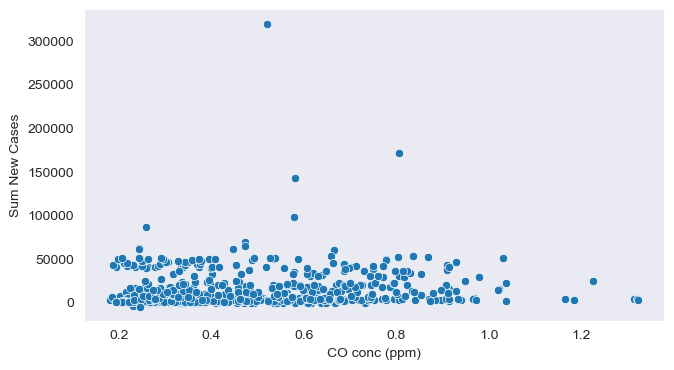

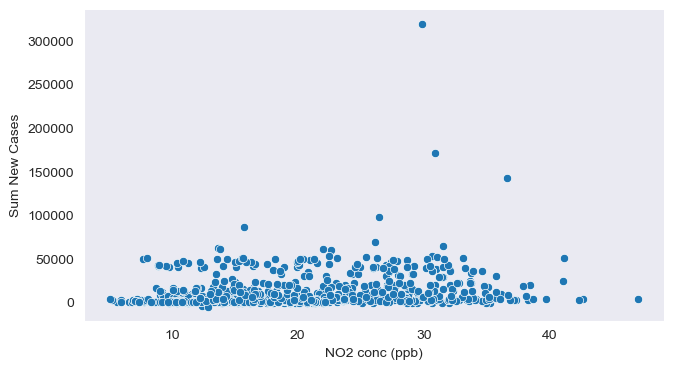

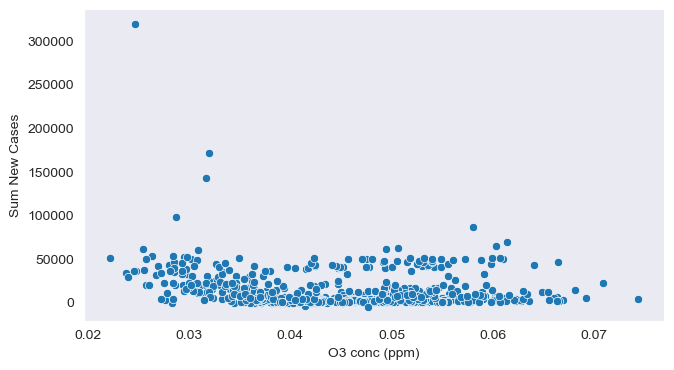

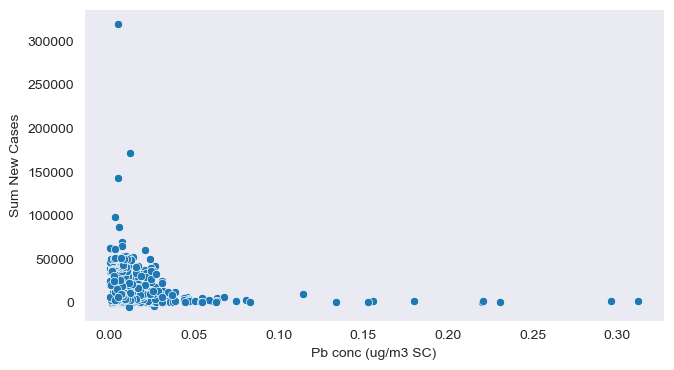

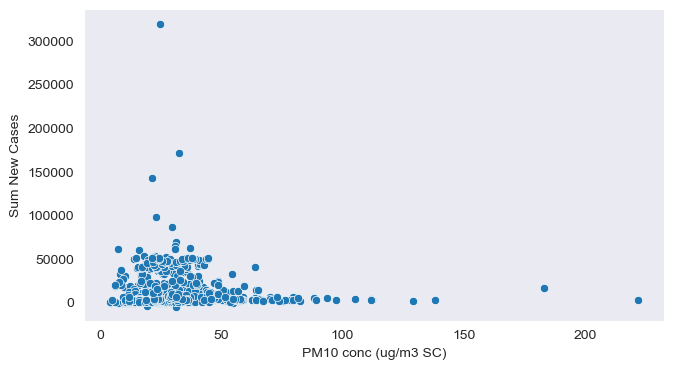

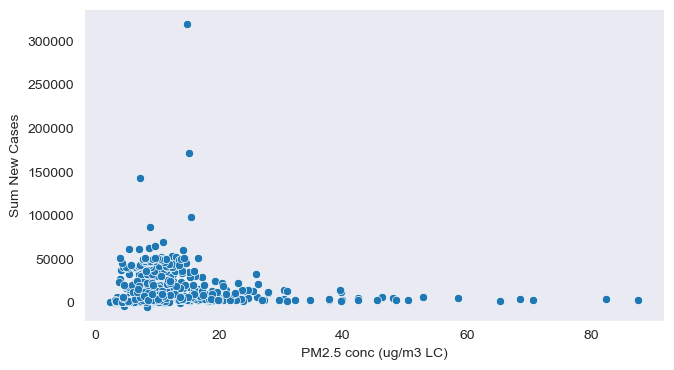

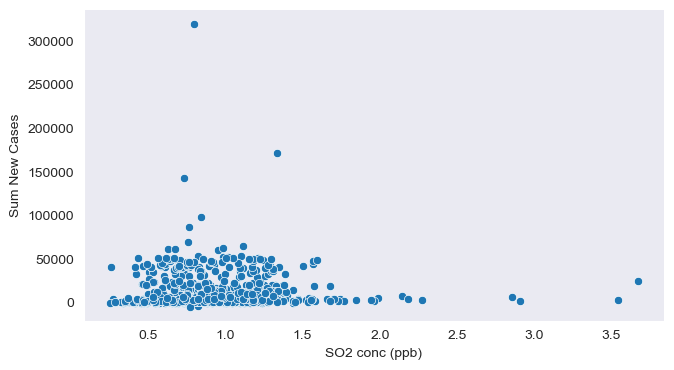

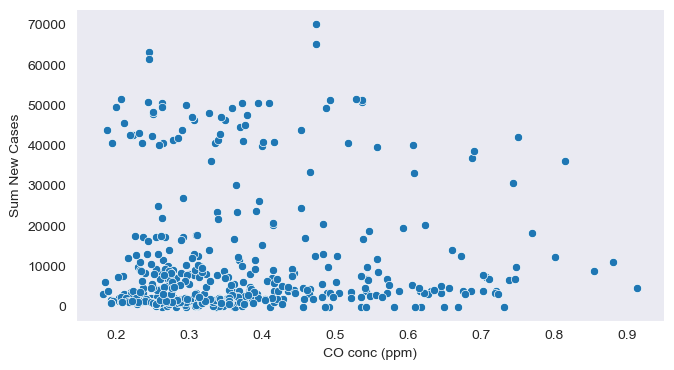

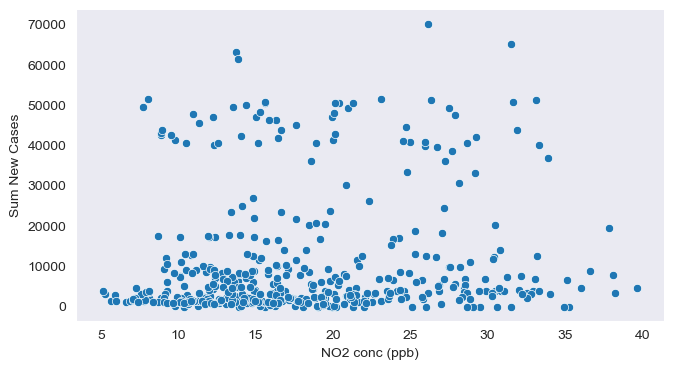

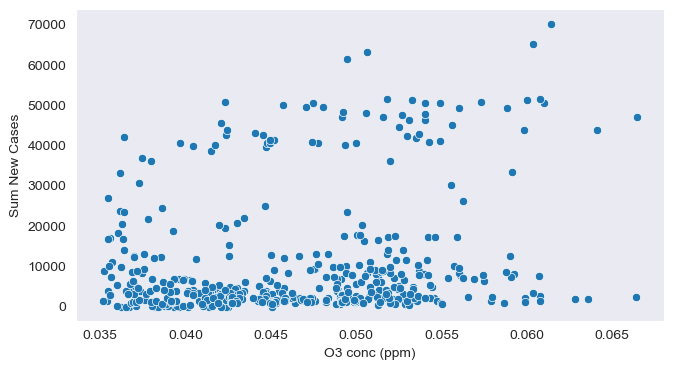

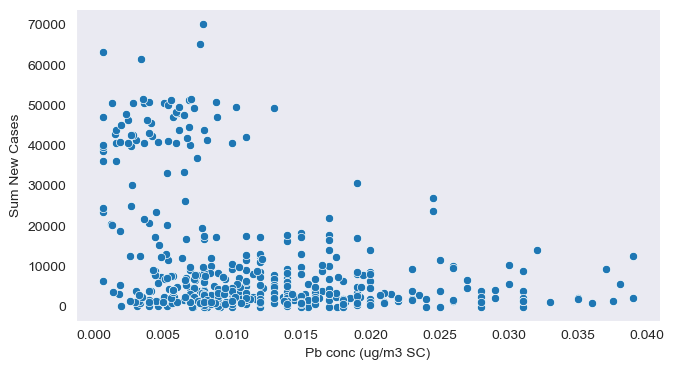

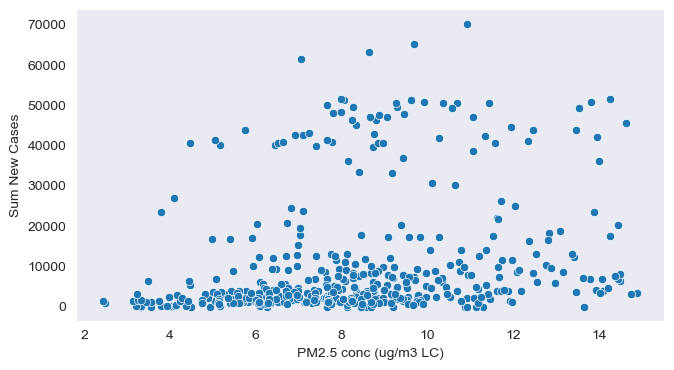

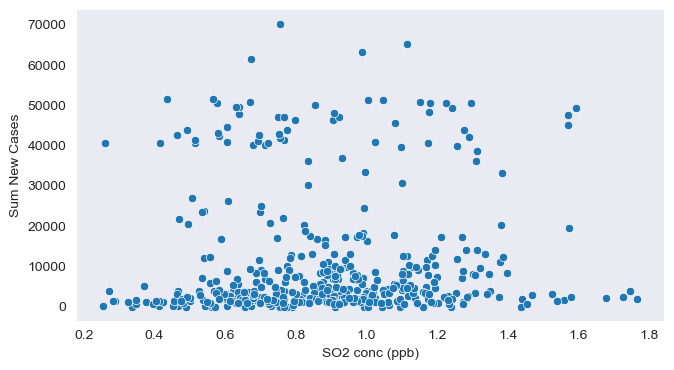

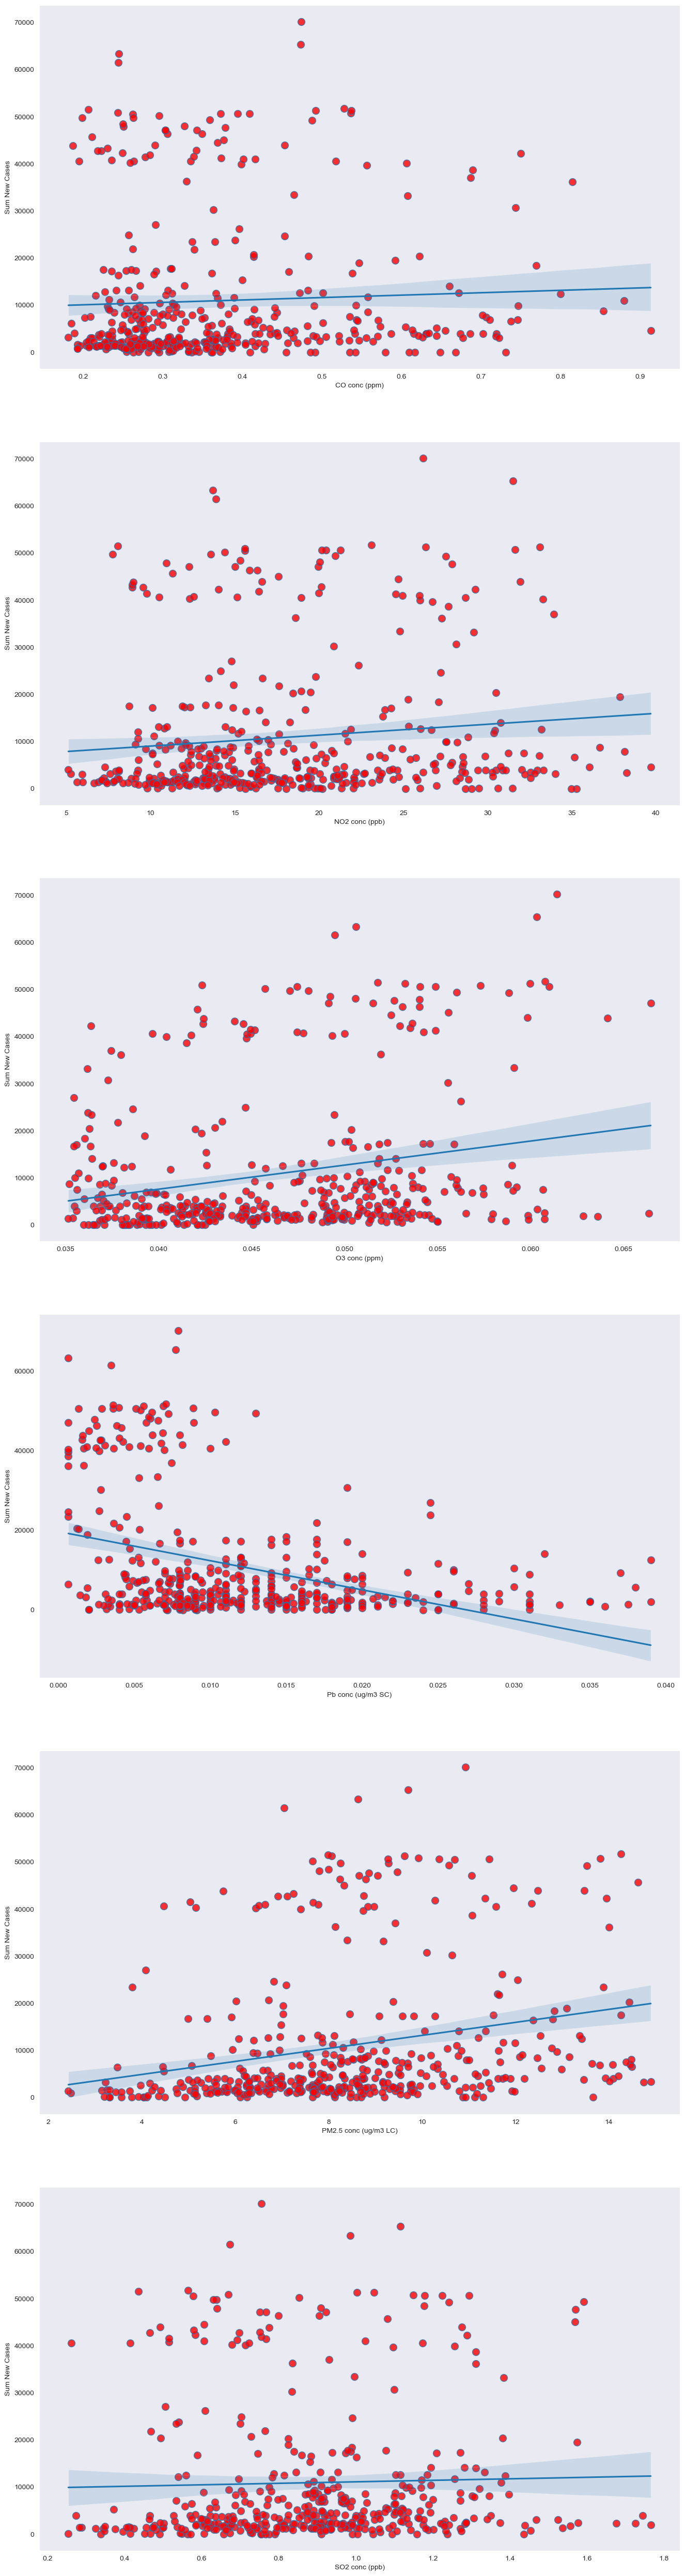

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

# The purpose of Date and State is done, drop them
data.drop(['Date', 'State'], axis=1, inplace=True)

# GENERATE SCATTERPLOTS FOR EDUCATED GUESSES OF WHAT COLUMNS TO USE
print("Scatterplots before pruning:")
for label in data.columns:
    if label in ['Sum New Cases', 'Total Cases', 'Confirmed Cases']: continue
    sns.set_style('dark')

    sns.relplot(x=label, y='Sum New Cases', data=data, height=3.8, aspect=1.8, kind='scatter')

print("Number of entries remaining BEFORE pruning:", data.shape[0])

# DYNAMIC PRUNING
# IDEA: We focus on ambient level of pollutants and ignore sudden spikes in COVID-19 case data (i.e. data dumps).
# We also remove Dates where there are no new infections as their volume skews the data alot.
# Currently visible values are most likely plateaus after painstaking tuning.
data = data[(data['Sum New Cases'] <= 73000) & (data['Sum New Cases'] > 1)]
data = data[(data['Total Cases'] > 0)]
data = data[(data['Confirmed Cases'] > 0)]
data = data[data['CO conc (ppm)'] <= 1.5]
# data = data[data['NO2 conc (ppb)'] > 1]   # pruning based on some columns hurts the metrics
data = data[data['O3 conc (ppm)'] > 0.035]
data = data[data['Pb conc (ug/m3 SC)'] < 0.04]
data = data[data['PM10 conc (ug/m3 SC)'] < 100]
data = data[data['PM2.5 conc (ug/m3 LC)'] < 15]
data = data[data['SO2 conc (ppb)'] < 2.0]

# DROP COLUMNS HERE
data.drop(columns=['PM10 conc (ug/m3 SC)'], axis=1, inplace=True)
# data = data[['PM10 conc (ug/m3 SC)', 'Sum New Cases']]

# SHOW scatterplots of pruned columns
print("Scatterplots after pruning")
for label in data.columns:
    if label in ['Sum New Cases', 'Total Cases', 'Confirmed Cases']: continue
    sns.set_style('dark')

    sns.relplot(x=label, y='Sum New Cases', data=data, height=3.8, aspect=1.8, kind='scatter')

print("Number of entries remaining AFTER pruning:", data.shape[0])

fig, axs = plt.subplots(nrows=len(data.columns)-3, ncols=1, figsize=(16,64))

i = 0
for label in data.columns:
    if label in ["Sum New Cases", "Total Cases", "Confirmed Cases"]: continue
    sns.regplot(x=label, y='Sum New Cases', data=data, ci=95, scatter_kws={'s':100, 'facecolor':'red'}, ax=axs[i])
    i += 1

# Linear Regression
# PREPARE FEATURES AND TARGET DATA (standardize first)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
scaler = MinMaxScaler()

# SPLIT DATA TO FEATURE SET AND TARGET
X = data.iloc[:,0:-1] # feature matrix
X = scaler.fit_transform(X)
y = data.iloc[:,-1] # target vector

# PREPARE TRAINING AND TESTING DATA
# NOTE: test_size is reduced to 20% because we have few records to work with especially after pruning
# (around 499 left from roughly 1000)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
import sklearn.linear_model as sklm
# MLPRegressor(random_state=1, max_iter=500)
regressor = LinearRegression()
alt1 = Ridge(alpha=0.5)
alt2 = SGDRegressor()

# from sklearn.model_selection import GridSearchCV
# grid_values = {'hidden_layer_sizes':[(2,),(5,),(100,)],'alpha':[0.001,.009,0.01,.09,1,5,10,25], 'activation':['logistic'], 'solver':['lbfgs'], 'learning_rate':['invscaling']}
# grid_clf_acc = GridSearchCV(regressor, param_grid = grid_values,scoring = 'neg_root_mean_squared_error')
# grid_clf_acc.fit(X_train, y_train)

regressor.fit(X_train, y_train)
alt1.fit(X_train, y_train)
alt2.fit(X_train, y_train)

# print("Coefficients:", regressor.coef_)
# print("Intercept:", regressor.intercept_)

y_pred = regressor.predict(X_test)
y_pred

y_pred1 = alt1.predict(X_test)
y_pred2 = alt2.predict(X_test)

In [65]:
# print(grid_clf_acc.best_params_)

# {'activation': 'logistic', 'alpha': 10, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}

,Actual,Predicted
347,30699.0,6470.658704
486,874.0,3739.637111
286,10968.0,8716.976226
49,20.0,1375.507920
439,2126.0,4869.342758
...,...,...
59,218.0,3229.679750
141,4515.0,5737.419693
628,11737.0,30717.569756
621,37012.0,31015.711511


347    24228.341296
486    -2865.637111
286     2251.023774
49     -1355.507920
439    -2743.342758
           ...     
59     -3011.679750
141    -1222.419693
628   -18980.569756
621     5996.288489
479    -5478.296365
Name: Sum New Cases, Length: 90, dtype: float64

<AxesSubplot:xlabel='Sum New Cases'>

Text(0.5, 0, 'y_test data')

Text(0, 0.5, 'Predictions')

MAE: 4611.868884302148
MSE 44201503.84038936
RMSE 6648.421153957484
R2 Score: 0.8536792298327127

FOR ALTERNATIVES:
ALT1 R2 Score: 0.7114388786067332
ALT2 R2 Score: 0.6994604645813851


['regressor.joblib']

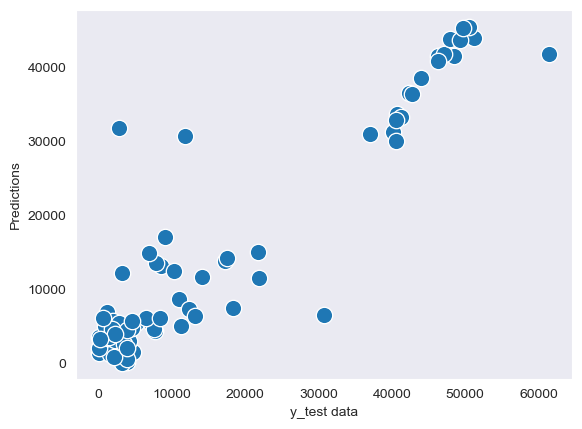

In [66]:
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparison_df

comparison_df1 = pd.DataFrame({"Actual":y_test,"Predicted":y_pred1})
comparison_df2 = pd.DataFrame({"Actual":y_test,"Predicted":y_pred2})

residuals = y_test - y_pred
residuals

residuals1 = y_test - y_pred1
residuals2 = y_test - y_pred2

sns.scatterplot(x=y_test, y = y_pred, s=140)
plt.xlabel('y_test data')
plt.ylabel('Predictions')

f = open("log2.out", "a")

from sklearn.metrics import mean_absolute_error
print('MAE:', mean_absolute_error(y_test,y_pred))
dump = f.write('MAE: {}\n'.format(mean_absolute_error(y_test,y_pred)))

from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))
dump = f.write('MSE: {}\n'.format(mean_squared_error(y_test,y_pred)))

import numpy as np
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
dump = f.write('RMSE: {}\n'.format(np.sqrt(mean_squared_error(y_test,y_pred))))

from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2 Score:", r2)      # We use this as our main metric
dump = f.write('R2 Score: {}\n'.format(r2))

dump = f.write('---\n')

# FOR ALTERNATIVES
print("\nFOR ALTERNATIVES:")
print("ALT1 R2 Score:", r2_score(y_test, y_pred1))
print("ALT2 R2 Score:", r2_score(y_test, y_pred2))

# SAVE MODEL
import joblib
joblib_file = "regressor.joblib"
joblib.dump(regressor, joblib_file)